In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from random import randint

In [2]:
f = open("categories.txt","r")
classes = f.readlines()
f.close()

In [3]:
category = [c.replace('\n','').replace(' ','_') for c in classes]

In [4]:
!mkdir Data

In [16]:
import urllib.request
import requests


def download():
    base_url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    save_folder = "Data"
    for category in classes:        
        clean_category = category.strip().replace(" ", "_")
        url = f"{base_url}{clean_category}.npy"
        response = requests.get(url)
        
        # Save the file locally in the Data folder
        file_path = os.path.join(save_folder, f"{clean_category}.npy")
        with open(file_path, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {file_path}")

In [17]:
download()

Downloaded Data\aircraft_carrier.npy
Downloaded Data\airplane.npy
Downloaded Data\alarm_clock.npy
Downloaded Data\ambulance.npy
Downloaded Data\angel.npy
Downloaded Data\animal_migration.npy
Downloaded Data\ant.npy
Downloaded Data\anvil.npy
Downloaded Data\apple.npy
Downloaded Data\arm.npy
Downloaded Data\asparagus.npy
Downloaded Data\axe.npy
Downloaded Data\backpack.npy
Downloaded Data\banana.npy
Downloaded Data\bandage.npy
Downloaded Data\barn.npy
Downloaded Data\baseball.npy
Downloaded Data\baseball_bat.npy
Downloaded Data\basket.npy
Downloaded Data\basketball.npy
Downloaded Data\bat.npy
Downloaded Data\bathtub.npy
Downloaded Data\beach.npy
Downloaded Data\bear.npy
Downloaded Data\beard.npy
Downloaded Data\bed.npy
Downloaded Data\bee.npy
Downloaded Data\belt.npy
Downloaded Data\bench.npy
Downloaded Data\bicycle.npy
Downloaded Data\binoculars.npy
Downloaded Data\bird.npy
Downloaded Data\birthday_cake.npy
Downloaded Data\blackberry.npy
Downloaded Data\blueberry.npy
Downloaded Data\boo

In [4]:

def load_data(root, vfold_ratio=0.2, max_items_per_class=8000):
    
    all_files = glob.glob(os.path.join(root, '*.npy'))
    x = np.empty([0, 784])
    y = np.empty([0])
    
    class_names = ["airplane", "bicycle", "bird", "birthday_cake", "candle", "car", "chair",
                    "cloud", "fish", "mountain", "octopus", "smiley_face","table",
                    "tree", "umbrella"]
    
    ## Load each data file
    #for idx, file in enumerate(all_files):
    #    data = np.load(file)
    #    data = data[0:max_items_per_class, :]
    #    labels = np.full(data.shape[0], idx)
    #    x = np.concatenate((x, data), axis=0)
    #    y = np.append(y, labels)
    #    class_name, _ = os.path.splitext(os.path.basename(file))
    #    class_names.append(class_name.replace('full_numpy_bitmap_','').title())
    
    # Load only the files for the defined class names
    for idx, class_name in enumerate(class_names):
        # Construct the file path for the specific class
        file_path = os.path.join(root, f"{class_name}.npy")
        
        # Check if the file exists
        if os.path.exists(file_path):
            # Load data from the file
            data = np.load(file_path)
            
            # Limit to `max_items_per_class` items
            data = data[:max_items_per_class, :]
            
            # Create labels for this class
            labels = np.full(data.shape[0], idx)
            
            # Concatenate data and labels
            x = np.concatenate((x, data), axis=0)
            y = np.append(y, labels)
        else:
            print(f"File not found for class: {class_name}")
    
    print(f"Data shape: {x.shape}")
    print(f"Labels shape: {y.shape}")
    
    # Randomize the dataset
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]
    
    # Split into training and testing
    vfold_size = int(x.shape[0] * vfold_ratio)
    x_test = x[:vfold_size, :]
    y_test = y[:vfold_size]
    x_train = x[vfold_size:, :]
    y_train = y[vfold_size:]
    
    return x_train, y_train, x_test, y_test, class_names

In [5]:
x_train, y_train, x_test, y_test, class_names = load_data(r"Data")
num_classes = len(class_names)

Data shape: (120000, 784)
Labels shape: (120000,)


In [6]:
y_train.shape

(96000,)

In [7]:
def preprocess_data(x_train, x_test, y_train, y_test, num_classes, image_size=28):
    
    # Reshape and normalize
    x_train = x_train.reshape(-1, image_size, image_size, 1).astype('float32') / 255.0
    x_test = x_test.reshape(-1, image_size, image_size, 1).astype('float32') / 255.0
    
    # Convert to categorical
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    return x_train, x_test, y_train, y_test

In [8]:

x_train, x_test, y_train, y_test = preprocess_data(
        x_train, x_test, y_train, y_test, num_classes
    )

In [9]:
def create_model(input_shape, num_classes):

    model = keras.Sequential([

        layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Flatten(),
        layers.Dropout(0.5),
        
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [10]:

model = create_model(x_train.shape[1:], num_classes)
model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:

callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2
        )
    ]

In [12]:

model.fit(
        x_train,
        y_train,
        batch_size=256,
        epochs=10,
        validation_split=0.1,
        callbacks=callbacks,
        verbose=1
    )

Epoch 1/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 44s 112ms/step - accuracy: 0.6319 - loss: 1.3073 - val_accuracy: 0.4544 - val_loss: 1.6162 - learning_rate: 0.0010
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 38s 114ms/step - accuracy: 0.8797 - loss: 0.4237 - val_accuracy: 0.9057 - val_loss: 0.3227 - learning_rate: 0.0010
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 38s 112ms/step - accuracy: 0.9032 - loss: 0.3358 - val_accuracy: 0.9247 - val_loss: 0.2617 - learning_rate: 0.0010
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 38s 112ms/step - accuracy: 0.9134 - loss: 0.2983 - val_accuracy: 0.9250 - val_loss: 0.2621 - learning_rate: 0.0010
Epoch 5/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 37s 108ms/step - accuracy: 0.9200 - loss: 0.2736 - val_accuracy: 0.9312 - val_loss: 0.2366 - learning_rate: 0.0010
Epoch 6/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 38s 113ms/step - accuracy: 0.9284 - loss: 0.2461 - val_accuracy: 0.9336 - val_loss: 0.2272 - learning_rate: 0.0010
Epoch 7/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 38s 112ms/step - accuracy: 0.9

In [13]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f'\nTest accuracy: {test_acc*100:.2f}%')


Test accuracy: 94.06%


In [22]:
def plot_sample(x_data, y_true, class_names, title="Sample Image"):
    idx = randint(0, len(x_data))
    plt.figure(figsize=(12, 12))
    plt.imshow(x_data[idx].reshape(28, 28), cmap='gray')
    plt.title(f"{title}\nClass: {class_names[int(y_true[idx])]}",
                fontweight='bold', fontsize=24)
    # Ensure text does not overlap
    plt.subplots_adjust(top=0.85) 
    plt.axis('off')
    plt.show()

In [15]:

def predict_drawing(image, top_k=5):
        pred = model.predict(np.expand_dims(image, axis=0))[0]
        top_indices = (-pred).argsort()[:top_k]
        return [class_names[i] for i in top_indices]

In [16]:

str(class_names)

"['airplane', 'bicycle', 'bird', 'birthday_cake', 'candle', 'car', 'chair', 'cloud', 'fish', 'mountain', 'octopus', 'smiley_face', 'table', 'tree', 'umbrella']"

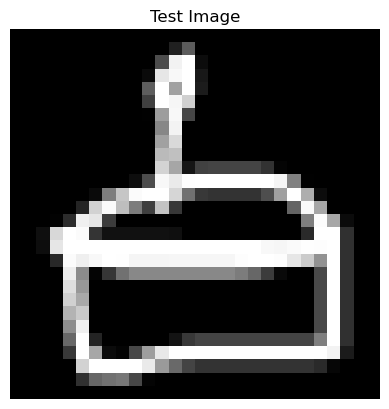

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step

Top 5 predictions: ['birthday_cake', 'candle', 'chair', 'table', 'airplane']


In [17]:
# Show sample prediction
idx = randint(0, len(x_test))
test_image = x_test[idx]

plt.imshow(test_image.squeeze(), cmap='gray')
plt.axis('off')
plt.title("Test Image")
plt.show()

predictions = predict_drawing(test_image)
print("\nTop 5 predictions:", predictions)

In [18]:

model.save("model50.keras")